In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Callable, List


class InterestRateModel:
    def __init__(self, r0: float, sigma: float, kappa: float, theta: float, dt: float, T: float):
        """
        Initialize the Interest Rate Model.

        Parameters:
        r0 (float): Initial interest rate.
        sigma (float): Volatility.
        kappa (float): Mean reversion rate.
        theta (float): Long-term mean.
        dt (float): Time step.
        T (float): Total time.
        """
        self.r0 = r0
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        self.dt = dt
        self.T = T
        self.n_steps = int(T / dt)
        self.times = np.linspace(0, T, self.n_steps)
    
    def euler_maruyama(self, n_paths: int) -> np.ndarray:
        """
        Simulate interest rate paths using Euler-Maruyama scheme.

        Parameters:
        n_paths (int): Number of Monte Carlo paths.

        Returns:
        np.ndarray: Simulated paths.
        """
        paths = np.zeros((n_paths, self.n_steps))
        paths[:, 0] = self.r0
        for t in range(1, self.n_steps):
            dW = np.random.normal(0, np.sqrt(self.dt), n_paths)
            paths[:, t] = paths[:, t-1] + self.kappa * (self.theta - paths[:, t-1]) * self.dt + self.sigma * dW
        return paths

    def milstein(self, n_paths: int) -> np.ndarray:
        """
        Simulate interest rate paths using Milstein scheme.

        Parameters:
        n_paths (int): Number of Monte Carlo paths.

        Returns:
        np.ndarray: Simulated paths.
        """
        paths = np.zeros((n_paths, self.n_steps))
        paths[:, 0] = self.r0
        for t in range(1, self.n_steps):
            dW = np.random.normal(0, np.sqrt(self.dt), n_paths)
            paths[:, t] = paths[:, t-1] + self.kappa * (self.theta - paths[:, t-1]) * self.dt + \
                          self.sigma * dW + 0.5 * self.sigma**2 * (dW**2 - self.dt)
        return paths

    def calibrate(self, market_data: np.ndarray, n_paths: int, scheme: Callable[[int], np.ndarray]):
        """
        Calibrate the model parameters to market data.

        Parameters:
        market_data (np.ndarray): Market observed data.
        n_paths (int): Number of Monte Carlo paths.
        scheme (Callable[[int], np.ndarray]): Simulation scheme (e.g., self.euler_maruyama).

        Returns:
        None
        """
        def objective(params):
            self.sigma, self.kappa, self.theta = params
            simulated_paths = scheme(n_paths)
            simulated_means = simulated_paths.mean(axis=0)
            return np.sum((simulated_means - market_data)**2)

        initial_guess = [self.sigma, self.kappa, self.theta]
        result = minimize(objective, initial_guess, method='L-BFGS-B')
        self.sigma, self.kappa, self.theta = result.x
    
    def plot_paths(self, paths: np.ndarray, title: str):
        """
        Plot simulated paths.

        Parameters:
        paths (np.ndarray): Simulated paths.
        title (str): Plot title.
        
        Returns:
        None
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.times, paths.T, lw=0.5)
        plt.title(title)
        plt.xlabel('Time')
        plt.ylabel('Interest Rate')
        plt.grid(True)
        plt.show()


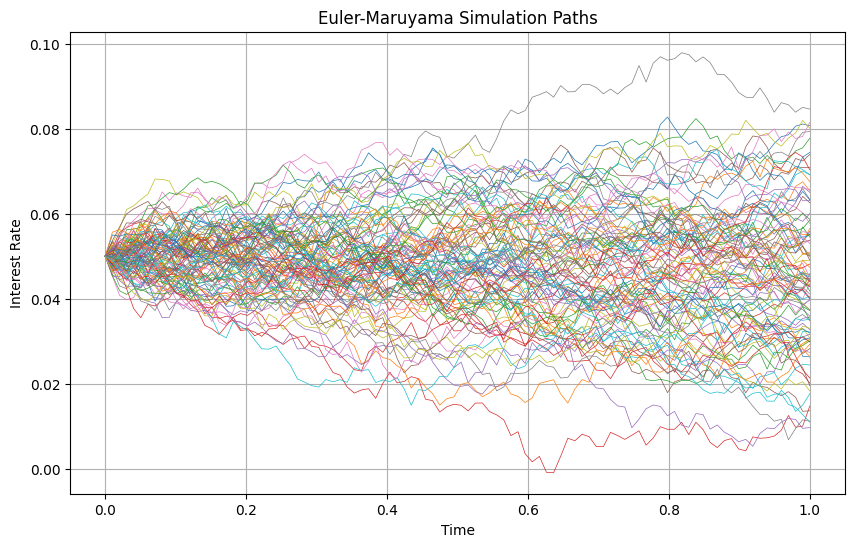

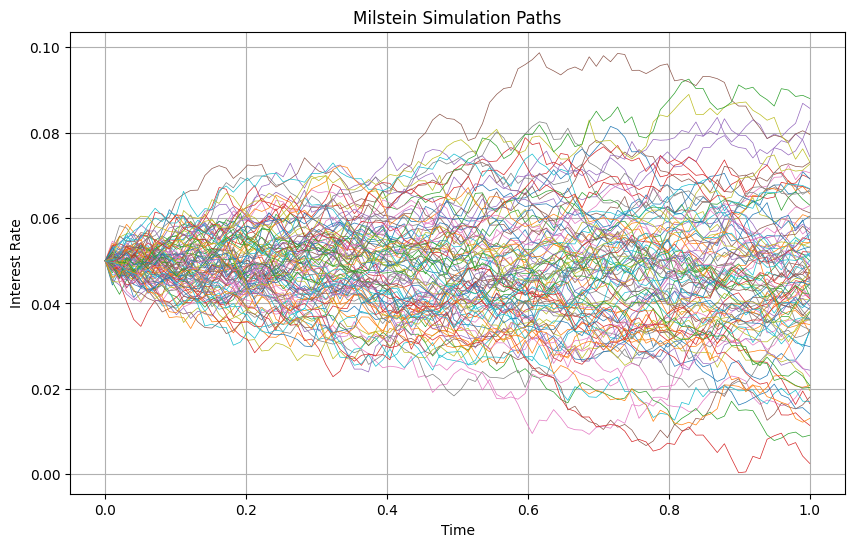

Calibrated sigma: 0.020000298715960534
Calibrated kappa: 0.3000007567317122
Calibrated theta: 0.03999965166808327


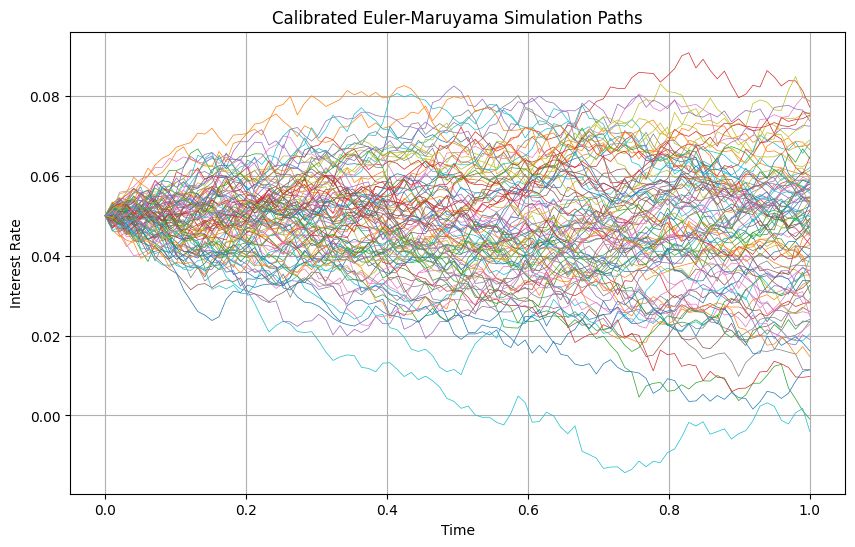

In [4]:
# Define parameters
r0 = 0.05
sigma = 0.02
kappa = 0.3
theta = 0.04
dt = 0.01
T = 1.0

# Initialize the model
model = InterestRateModel(r0, sigma, kappa, theta, dt, T)

# Simulate paths using Euler-Maruyama scheme
n_paths = 100
euler_paths = model.euler_maruyama(n_paths)

# Plot the simulated paths
model.plot_paths(euler_paths, "Euler-Maruyama Simulation Paths")

# Simulate paths using Milstein scheme
milstein_paths = model.milstein(n_paths)

# Plot the simulated paths
model.plot_paths(milstein_paths, "Milstein Simulation Paths")

# Generate synthetic market data (for demonstration purposes)
np.random.seed(42)
market_data = model.euler_maruyama(n_paths).mean(axis=0)

# Calibrate the model to the synthetic market data
model.calibrate(market_data, n_paths, model.euler_maruyama)

# Display calibrated parameters
print(f"Calibrated sigma: {model.sigma}")
print(f"Calibrated kappa: {model.kappa}")
print(f"Calibrated theta: {model.theta}")

# Re-simulate paths using calibrated parameters
calibrated_paths = model.euler_maruyama(n_paths)
model.plot_paths(calibrated_paths, "Calibrated Euler-Maruyama Simulation Paths")
